# Gradient Boosting

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE

from src import ensemble_utils

### Import Data

In [6]:
accidents = pd.read_csv('data/accidents.csv', index_cGradientBoostingClassifiereature in enumerate(accidents.columns):
    print('{}. {}'.format(idx, feature))

0. RD_NO
1. CRASH_DATE
2. POSTED_SPEED_LIMIT
3. TRAFFIC_CONTROL_DEVICE
4. DEVICE_CONDITION
5. WEATHER_CONDITION
6. LIGHTING_CONDITION
7. FIRST_CRASH_TYPE
8. TRAFFICWAY_TYPE
9. LANE_CNT
10. ALIGNMENT
11. ROADWAY_SURFACE_COND
12. ROAD_DEFECT
13. CRASH_TYPE
14. INTERSECTION_RELATED_I
15. NOT_RIGHT_OF_WAY_I
16. HIT_AND_RUN_I
17. PRIM_CONTRIBUTORY_CAUSE
18. SEC_CONTRIBUTORY_CAUSE
19. STREET_NO
20. STREET_DIRECTION
21. STREET_NAME
22. BEAT_OF_OCCURRENCE
23. WORK_ZONE_I
24. WORK_ZONE_TYPE
25. WORKERS_PRESENT_I
26. INJURIES_UNKNOWN
27. CRASH_HOUR
28. CRASH_DAY_OF_WEEK
29. LATITUDE
30. LONGITUDE
31. LOCATION
32. crash_date
33. crash_year
34. crash_month
35. is_fatal_or_incap
36. time_of_day
37. is_weekend
38. season
39. is_cyclist
40. is_pedestrian
41. is_head_on
42. is_parked
43. is_using_cellphone
44. has_disregarded_traffic_devices
45. is_failed_to_yield_right_of_way
46. is_reckless_driving
47. is_sleet_snow
48. is_rain
49. is_clear_weather
50. has_snow_ice
51. is_dark_no_lighting
52. has_st

### Process Data

In [7]:
indices = [2, 37] + list(range(39, 64))
selected_features = list(accidents.columns[indices])

X = accidents[selected_features]
y = accidents['is_fatal_or_incap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [10]:
oversampler = RandomOverSampler(sampling_strategy=0.75, random_state=3)
#oversampler = SMOTE(sampling_strategy=0.5, random_state=3)

X_over, y_over = oversampler.fit_resample(X_train.to_numpy(), y_train.to_numpy())

### Hyperparameter Tuning

In [11]:
n_estimators = [10, 50, 100]
learning_rates = [0.001, 0.01, 0.1, 1, 10]
max_depth = [1, 2, 3]
params_grid = dict(n_estimators=n_estimators,
                   learning_rate=learning_rates,
                   max_depth=max_depth)

In [12]:
gbt = GradientBoostingClassifier(random_state=3)

clf = GridSearchCV(gbt, params_grid, cv=5, verbose=0, scoring='recall')

best_model = clf.fit(X_over, y_over)

In [ ]:
print('Optimal # of Estimators: ', best_model.best_estimator_.get_params()['n_estimators'])
print('Optimal Learning Rate: ', best_model.best_estimator_.get_params()['learning_rate'])
print('Max. Depth of Tree: ', best_model.best_estimator_.get_params()['max_depth'])

### Train and Predict

In [15]:
n_estimators = 50
learning_rate = 0.01 
max_depth = 2

gbt = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=3)
gbt.fit(X_over, y_over)
y_pred = gbt.predict(X_test)
y_prob = gbt.predict_proba(X_test)[:, 1]


cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('\n')
print('Recall (Scores FN): ', round(recall_score(y_test, y_pred), 4))
print('Precision (Scores FP): ', round(precision_score(y_test, y_pred), 4))
print('AUC Score: ', round(roc_auc_score(y_test, y_prob), 4))

[[55420  2130]
 [  712   353]]


Recall (Scores FN):  0.3315
Precision (Scores FP):  0.1422
AUC Score:  0.6912


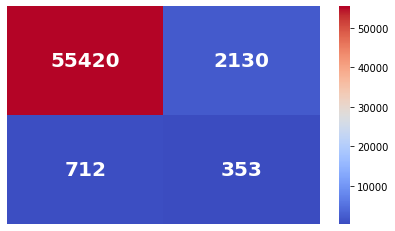

In [16]:
plt.figure(figsize=(7,4))
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, annot_kws={'size': 20, 'fontweight':'bold'}, fmt='d',
                 xticklabels=False, yticklabels=False);
#plt.savefig('img/cf_matrix.png', bbox_inches='tight')

### Permutation Importance

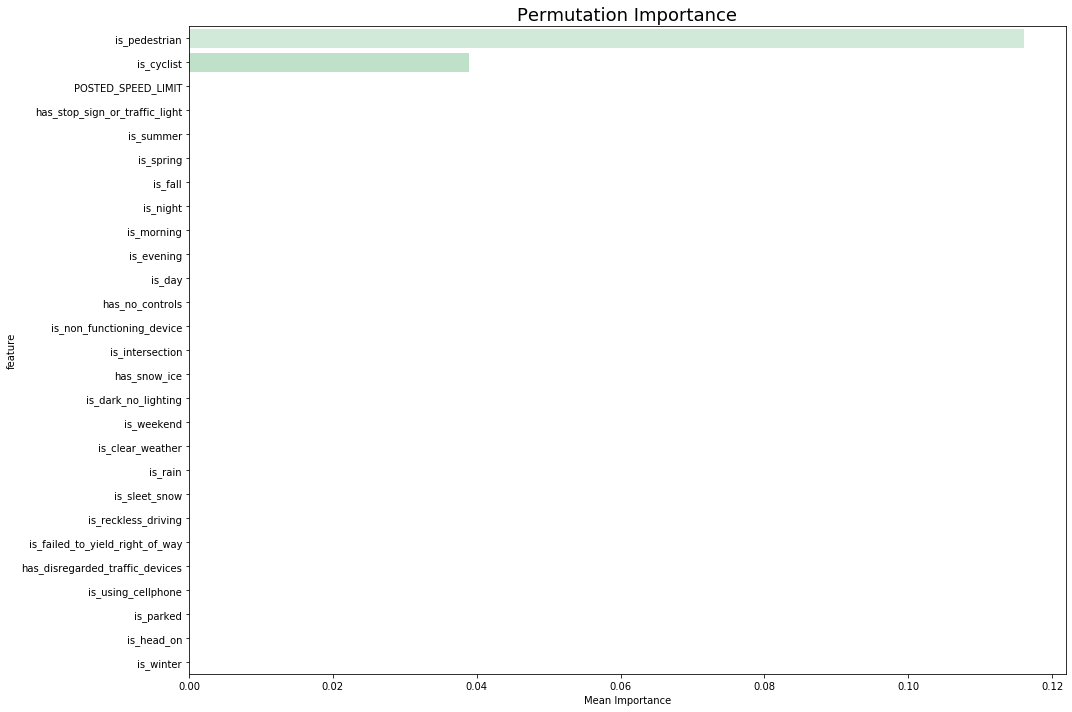

In [17]:
ensemble_utils.calculate_and_plot_permutation_importance(gbt, X_over, y_over, 20, 3, (15,10), 16, X_train.columns)